### CREDIT

This notebook is prepared by the guidance of Jesús Martínez's book, which is Tensorflow 2.0 Computer Vision Cookbook. Most of the code blocks and explanations are taken from this book. You can reach original codes and detailed explanations from book or from github repo of the book (https://github.com/PacktPublishing/Tensorflow-2.0-Computer-Vision-Cookbook).



#### WHAT IS THIS NOTEBOOK

This notebook is an example about DCGAN by keras and TF. We will implement DCGAN for EMNIST..

You can check book for details (Chapter 6, recipe-1)

#### Keywords

* DCGAN
* GAN
* TF
* EMNIST dataset

'' The discriminator is just a regular Convolutional Neural Network (CNN) that must solve the binary classification problem of distinguishing real images from fakes. The generator, on the other hand, is similar to the decoder in an autoencoder because it has to produce an image from a seed, which is just a vector of Gaussian noise. ''

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

C:\Users\Zeki\anaconda3\envs\githubtf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE


class DCGAN(object):
    def __init__(self):
        self.loss = BinaryCrossentropy(from_logits=True)
        self.generator = self.create_generator()
        self.discriminator = self.create_discriminator()
        self.generator_opt = Adam(learning_rate=1e-4)
        self.discriminator_opt = Adam(learning_rate=1e-4)

    @staticmethod
    def create_generator(alpha=0.2):
        input = Input(shape=(100,))
        x = Dense(units=7 * 7 * 256, use_bias=False)(input)
        x = LeakyReLU(alpha=alpha)(x)
        x = BatchNormalization()(x)

        x = Reshape((7, 7, 256))(x)

        x = Conv2DTranspose(filters=128,
                            strides=(1, 1),
                            kernel_size=(5, 5),
                            padding='same',
                            use_bias=False)(x)
        x = LeakyReLU(alpha=alpha)(x)
        x = BatchNormalization()(x)

        x = Conv2DTranspose(filters=64,
                            strides=(2, 2),
                            kernel_size=(5, 5),
                            padding='same',
                            use_bias=False)(x)
        x = LeakyReLU(alpha=alpha)(x)
        x = BatchNormalization()(x)

        x = Conv2DTranspose(filters=1,
                            strides=(2, 2),
                            kernel_size=(5, 5),
                            padding='same',
                            use_bias=False)(x)
        output = Activation('tanh')(x)

        return Model(input, output)

    @staticmethod
    def create_discriminator(alpha=0.2, dropout=0.3):
        input = Input(shape=(28, 28, 1))
        x = Conv2D(filters=64,
                   kernel_size=(5, 5),
                   strides=(2, 2),
                   padding='same')(input)
        x = LeakyReLU(alpha=alpha)(x)
        x = Dropout(rate=dropout)(x)

        x = Conv2D(filters=128,
                   kernel_size=(5, 5),
                   strides=(2, 2),
                   padding='same')(x)
        x = LeakyReLU(alpha=alpha)(x)
        x = Dropout(rate=dropout)(x)

        x = Flatten()(x)
        output = Dense(units=1)(x)

        return Model(input, output)

    def discriminator_loss(self, real, fake):
        real_loss = self.loss(tf.ones_like(real), real)
        fake_loss = self.loss(tf.zeros_like(fake), fake)

        return real_loss + fake_loss

    def generator_loss(self, fake):
        return self.loss(tf.ones_like(fake), fake)

    @tf.function
    def train_step(self, images, batch_size):
        noise = tf.random.normal((batch_size, noise_dimension))

        with tf.GradientTape() as gen_tape, \
                tf.GradientTape() as dis_tape:
            generated_images = self.generator(noise,
                                              training=True)

            real = self.discriminator(images, training=True)
            fake = self.discriminator(generated_images,
                                      training=True)

            gen_loss = self.generator_loss(fake)
            disc_loss = self.discriminator_loss(real, fake)

        generator_grad = gen_tape \
            .gradient(gen_loss,
                      self.generator.trainable_variables)
        discriminator_grad = dis_tape \
            .gradient(disc_loss,
                      self.discriminator.trainable_variables)

        opt_args = zip(generator_grad,
                       self.generator.trainable_variables)
        self.generator_opt.apply_gradients(opt_args)

        opt_args = zip(discriminator_grad,
                       self.discriminator.trainable_variables)
        self.discriminator_opt.apply_gradients(opt_args)

    def train(self, dataset, test_seed, epochs, batch_size):
        for epoch in tqdm(range(epochs)):
            for image_batch in dataset:
                self.train_step(image_batch, batch_size)

            if epoch == 0 or epoch % 10 == 0:
                generate_and_save_images(self.generator,
                                         epoch,
                                         test_seed)



In [3]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        image = predictions[i, :, :, 0] * 127.5 + 127.5
        image = tf.cast(image, tf.uint8)
        plt.imshow(image, cmap='gray')
        plt.axis('off')

    plt.savefig(f'{epoch}.png')
    plt.show()

In [4]:
def process_image(input):
    image = tf.cast(input['image'], tf.float32)
    image = (image - 127.5) / 127.5
    return image

In [5]:
BUFFER_SIZE = 1000
BATCH_SIZE = 512
EPOCHS = 200

In [6]:
data = tfds.load('emnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Size...:   0%|          | 0/535 [00:01<?, ? MiB/s]

Extraction completed...: 0 file [00:01, ? file/s]
Dl Size...:   0%|          | 1/535 [00:05<46:10,  5.19s/ MiB]

Extraction completed...: 0 file [00:05, ? file/s]
Dl Size...:   0%|          | 2/535 [00:07<33:34,  3.78s/ MiB]

Extraction completed...: 0 file [00:07, ? file/s]
Dl Size...:   1%|          | 3/535 [00:09<24:33,  2.77s/ MiB]

Extraction completed...: 0 file [00:09, ? file/s]
Dl Size...:   1%|          | 4/535 [00:10<17:37,  1.99s/ MiB]

Extraction completed...: 0 file [00:10, ? file/s]
Dl Size...:   1%|          | 5/535 [00:11<15:53,  1.80s/ MiB]

Extraction completed...: 0 file [00:11, ? file/s]
Dl Size...:   1%|          | 6/535 [00:14<17:28,  1.98s/ MiB]

Extraction completed...: 0 file [00:14, ? file/s]
Dl Size...:   1%|▏         | 7/535 [00:15<16:11,

Dl Size...:   8%|▊         | 43/535 [00:51<03:32,  2.31 MiB/s]

Extraction completed...: 0 file [00:51, ? file/s]
Dl Size...:   8%|▊         | 44/535 [00:51<03:08,  2.60 MiB/s]

Extraction completed...: 0 file [00:51, ? file/s]
Dl Size...:   8%|▊         | 45/535 [00:51<02:53,  2.83 MiB/s]

Extraction completed...: 0 file [00:51, ? file/s]
Dl Size...:   9%|▊         | 46/535 [00:51<02:17,  3.55 MiB/s]

Extraction completed...: 0 file [00:51, ? file/s]
Dl Size...:   9%|▉         | 47/535 [00:52<02:11,  3.70 MiB/s]

Extraction completed...: 0 file [00:52, ? file/s]
Dl Size...:   9%|▉         | 48/535 [00:52<02:00,  4.05 MiB/s]

Extraction completed...: 0 file [00:52, ? file/s]
Dl Size...:   9%|▉         | 49/535 [00:52<02:02,  3.95 MiB/s]

Extraction completed...: 0 file [00:52, ? file/s]
Dl Size...:   9%|▉         | 50/535 [00:52<01:51,  4.36 MiB/s]

Extraction completed...: 0 file [00:52, ? file/s]
Dl Size...:  10%|▉         | 51/535 [00:52<01:48,  4.46 MiB/s]

Extraction completed...:

Dl Size...:  16%|█▌        | 86/535 [01:02<01:53,  3.94 MiB/s]

Extraction completed...: 0 file [01:02, ? file/s]
Dl Size...:  16%|█▋        | 87/535 [01:02<01:49,  4.08 MiB/s]

Extraction completed...: 0 file [01:02, ? file/s]
Dl Size...:  16%|█▋        | 88/535 [01:02<02:05,  3.55 MiB/s]

Extraction completed...: 0 file [01:02, ? file/s]
Dl Size...:  17%|█▋        | 89/535 [01:03<03:05,  2.41 MiB/s]

Extraction completed...: 0 file [01:03, ? file/s]
Dl Size...:  17%|█▋        | 90/535 [01:03<03:14,  2.29 MiB/s]

Extraction completed...: 0 file [01:03, ? file/s]
Dl Size...:  17%|█▋        | 91/535 [01:04<03:36,  2.05 MiB/s]

Extraction completed...: 0 file [01:04, ? file/s]
Dl Size...:  17%|█▋        | 92/535 [01:05<04:13,  1.74 MiB/s]

Extraction completed...: 0 file [01:05, ? file/s]
Dl Size...:  17%|█▋        | 93/535 [01:05<04:11,  1.76 MiB/s]

Extraction completed...: 0 file [01:05, ? file/s]
Dl Size...:  18%|█▊        | 94/535 [01:07<05:28,  1.34 MiB/s]

Extraction completed...:

Dl Size...:  24%|██▍       | 130/535 [01:29<02:17,  2.94 MiB/s]

Extraction completed...: 0 file [01:29, ? file/s]
Dl Size...:  24%|██▍       | 131/535 [01:29<02:10,  3.11 MiB/s]

Extraction completed...: 0 file [01:29, ? file/s]
Dl Size...:  25%|██▍       | 132/535 [01:29<02:17,  2.93 MiB/s]

Extraction completed...: 0 file [01:29, ? file/s]
Dl Size...:  25%|██▍       | 133/535 [01:30<03:19,  2.02 MiB/s]

Extraction completed...: 0 file [01:30, ? file/s]
Dl Size...:  25%|██▌       | 134/535 [01:33<08:24,  1.26s/ MiB]

Extraction completed...: 0 file [01:33, ? file/s]
Dl Size...:  25%|██▌       | 135/535 [01:35<08:18,  1.25s/ MiB]

Extraction completed...: 0 file [01:35, ? file/s]
Dl Size...:  25%|██▌       | 136/535 [01:35<07:35,  1.14s/ MiB]

Extraction completed...: 0 file [01:35, ? file/s]
Dl Size...:  26%|██▌       | 137/535 [01:36<06:24,  1.03 MiB/s]

Extraction completed...: 0 file [01:36, ? file/s]
Dl Size...:  26%|██▌       | 138/535 [01:36<05:04,  1.30 MiB/s]

Extraction comp

Dl Size...:  32%|███▏      | 173/535 [01:47<01:09,  5.18 MiB/s]

Extraction completed...: 0 file [01:47, ? file/s]
Dl Size...:  33%|███▎      | 174/535 [01:47<01:09,  5.17 MiB/s]

Extraction completed...: 0 file [01:47, ? file/s]
Dl Size...:  33%|███▎      | 175/535 [01:47<01:20,  4.49 MiB/s]

Extraction completed...: 0 file [01:47, ? file/s]
Dl Size...:  33%|███▎      | 176/535 [01:48<01:30,  3.96 MiB/s]

Extraction completed...: 0 file [01:48, ? file/s]
Dl Size...:  33%|███▎      | 177/535 [01:48<01:28,  4.04 MiB/s]

Extraction completed...: 0 file [01:48, ? file/s]
Dl Size...:  33%|███▎      | 178/535 [01:48<01:23,  4.28 MiB/s]

Extraction completed...: 0 file [01:48, ? file/s]
Dl Size...:  33%|███▎      | 179/535 [01:48<01:28,  4.01 MiB/s]

Extraction completed...: 0 file [01:48, ? file/s]
Dl Size...:  34%|███▎      | 180/535 [01:48<01:19,  4.44 MiB/s]

Extraction completed...: 0 file [01:48, ? file/s]
Dl Size...:  34%|███▍      | 181/535 [01:49<01:16,  4.61 MiB/s]

Extraction comp

Extraction completed...: 0 file [01:58, ? file/s]
Dl Size...:  41%|████      | 217/535 [01:58<01:42,  3.09 MiB/s]

Extraction completed...: 0 file [01:58, ? file/s]
Dl Size...:  41%|████      | 218/535 [01:59<01:53,  2.78 MiB/s]

Extraction completed...: 0 file [01:59, ? file/s]
Dl Size...:  41%|████      | 219/535 [01:59<02:21,  2.23 MiB/s]

Extraction completed...: 0 file [01:59, ? file/s]
Dl Size...:  41%|████      | 220/535 [02:00<02:10,  2.41 MiB/s]

Extraction completed...: 0 file [02:00, ? file/s]
Dl Size...:  41%|████▏     | 221/535 [02:00<02:13,  2.35 MiB/s]

Extraction completed...: 0 file [02:00, ? file/s]
Dl Size...:  41%|████▏     | 222/535 [02:01<02:00,  2.61 MiB/s]

Extraction completed...: 0 file [02:01, ? file/s]
Dl Size...:  42%|████▏     | 223/535 [02:01<01:42,  3.06 MiB/s]

Extraction completed...: 0 file [02:01, ? file/s]
Dl Size...:  42%|████▏     | 224/535 [02:01<01:22,  3.78 MiB/s]

Extraction completed...: 0 file [02:01, ? file/s]
Dl Size...:  42%|████▏     | 2

Dl Size...:  49%|████▊     | 260/535 [02:19<01:42,  2.67 MiB/s]

Extraction completed...: 0 file [02:19, ? file/s]
Dl Size...:  49%|████▉     | 261/535 [02:20<01:49,  2.50 MiB/s]

Extraction completed...: 0 file [02:20, ? file/s]
Dl Size...:  49%|████▉     | 262/535 [02:20<01:34,  2.88 MiB/s]

Extraction completed...: 0 file [02:20, ? file/s]
Dl Size...:  49%|████▉     | 263/535 [02:20<01:21,  3.33 MiB/s]

Extraction completed...: 0 file [02:20, ? file/s]
Dl Size...:  49%|████▉     | 264/535 [02:20<01:17,  3.50 MiB/s]

Dl Size...:  50%|████▉     | 265/535 [02:20<01:17,  3.50 MiB/s]

Extraction completed...: 0 file [02:20, ? file/s]
Dl Size...:  50%|████▉     | 266/535 [02:21<01:33,  2.87 MiB/s]

Extraction completed...: 0 file [02:21, ? file/s]
Dl Size...:  50%|████▉     | 267/535 [02:21<01:30,  2.96 MiB/s]

Extraction completed...: 0 file [02:21, ? file/s]
Dl Size...:  50%|█████     | 268/535 [02:22<01:30,  2.95 MiB/s]

Extraction completed...: 0 file [02:22, ? file/s]
Dl Size...:  50

Extraction completed...: 0 file [02:32, ? file/s]
Dl Size...:  57%|█████▋    | 304/535 [02:32<00:54,  4.26 MiB/s]

Extraction completed...: 0 file [02:32, ? file/s]
Dl Size...:  57%|█████▋    | 305/535 [02:33<00:56,  4.09 MiB/s]

Extraction completed...: 0 file [02:33, ? file/s]
Dl Size...:  57%|█████▋    | 306/535 [02:33<01:16,  2.98 MiB/s]

Extraction completed...: 0 file [02:33, ? file/s]
Dl Size...:  57%|█████▋    | 307/535 [02:33<01:11,  3.19 MiB/s]

Extraction completed...: 0 file [02:33, ? file/s]
Dl Size...:  58%|█████▊    | 308/535 [02:34<01:04,  3.50 MiB/s]

Extraction completed...: 0 file [02:34, ? file/s]
Dl Size...:  58%|█████▊    | 309/535 [02:34<01:01,  3.70 MiB/s]

Extraction completed...: 0 file [02:34, ? file/s]
Dl Size...:  58%|█████▊    | 310/535 [02:34<00:55,  4.07 MiB/s]

Dl Size...:  58%|█████▊    | 311/535 [02:34<00:54,  4.07 MiB/s]

Extraction completed...: 0 file [02:34, ? file/s]
Dl Size...:  58%|█████▊    | 312/535 [02:34<00:39,  5.67 MiB/s]

Extraction comp

Dl Size...:  65%|██████▍   | 347/535 [02:41<00:32,  5.85 MiB/s]

Extraction completed...: 0 file [02:41, ? file/s]
Dl Size...:  65%|██████▌   | 348/535 [02:42<00:31,  5.85 MiB/s]

Extraction completed...: 0 file [02:42, ? file/s]
Dl Size...:  65%|██████▌   | 349/535 [02:42<00:35,  5.19 MiB/s]

Extraction completed...: 0 file [02:42, ? file/s]
Dl Size...:  65%|██████▌   | 350/535 [02:42<00:32,  5.68 MiB/s]

Extraction completed...: 0 file [02:42, ? file/s]
Dl Size...:  66%|██████▌   | 351/535 [02:42<00:31,  5.75 MiB/s]

Extraction completed...: 0 file [02:42, ? file/s]
Dl Size...:  66%|██████▌   | 352/535 [02:42<00:34,  5.33 MiB/s]

Extraction completed...: 0 file [02:42, ? file/s]
Dl Size...:  66%|██████▌   | 353/535 [02:43<00:34,  5.22 MiB/s]

Extraction completed...: 0 file [02:43, ? file/s]
Dl Size...:  66%|██████▌   | 354/535 [02:43<00:39,  4.60 MiB/s]

Extraction completed...: 0 file [02:43, ? file/s]
Dl Size...:  66%|██████▋   | 355/535 [02:43<00:48,  3.73 MiB/s]

Extraction comp

Dl Size...:  73%|███████▎  | 390/535 [03:00<01:23,  1.74 MiB/s]

Extraction completed...: 0 file [03:00, ? file/s]
Dl Size...:  73%|███████▎  | 391/535 [03:00<01:05,  2.20 MiB/s]

Extraction completed...: 0 file [03:00, ? file/s]
Dl Size...:  73%|███████▎  | 392/535 [03:00<00:52,  2.70 MiB/s]

Extraction completed...: 0 file [03:00, ? file/s]
Dl Size...:  73%|███████▎  | 393/535 [03:01<00:45,  3.13 MiB/s]

Extraction completed...: 0 file [03:01, ? file/s]
Dl Size...:  74%|███████▎  | 394/535 [03:01<01:04,  2.18 MiB/s]

Extraction completed...: 0 file [03:01, ? file/s]
Dl Size...:  74%|███████▍  | 395/535 [03:02<01:07,  2.09 MiB/s]

Extraction completed...: 0 file [03:02, ? file/s]
Dl Size...:  74%|███████▍  | 396/535 [03:02<00:59,  2.33 MiB/s]

Extraction completed...: 0 file [03:02, ? file/s]
Dl Size...:  74%|███████▍  | 397/535 [03:02<00:50,  2.76 MiB/s]

Extraction completed...: 0 file [03:02, ? file/s]
Dl Size...:  74%|███████▍  | 398/535 [03:03<00:52,  2.62 MiB/s]

Extraction comp

Extraction completed...: 0 file [03:53, ? file/s]
Dl Size...:  81%|████████  | 434/535 [03:59<06:02,  3.59s/ MiB]

Dl Size...:  81%|████████▏ | 435/535 [03:59<05:59,  3.59s/ MiB]

Extraction completed...: 0 file [03:59, ? file/s]
Dl Size...:  81%|████████▏ | 436/535 [04:01<03:50,  2.33s/ MiB]

Extraction completed...: 0 file [04:01, ? file/s]
Dl Size...:  82%|████████▏ | 437/535 [04:03<03:42,  2.27s/ MiB]

Extraction completed...: 0 file [04:03, ? file/s]
Dl Size...:  82%|████████▏ | 438/535 [04:05<03:38,  2.25s/ MiB]

Extraction completed...: 0 file [04:05, ? file/s]
Dl Size...:  82%|████████▏ | 439/535 [04:08<03:47,  2.37s/ MiB]

Extraction completed...: 0 file [04:08, ? file/s]
Dl Size...:  82%|████████▏ | 440/535 [04:10<03:41,  2.33s/ MiB]

Extraction completed...: 0 file [04:10, ? file/s]
Dl Size...:  82%|████████▏ | 441/535 [04:12<03:34,  2.28s/ MiB]

Extraction completed...: 0 file [04:12, ? file/s]
Dl Size...:  83%|████████▎ | 442/535 [04:15<03:29,  2.25s/ MiB]

Extraction comp

Extraction completed...: 0 file [05:09, ? file/s]
Dl Size...:  89%|████████▉ | 478/535 [05:12<02:17,  2.42s/ MiB]

Extraction completed...: 0 file [05:11, ? file/s]
Dl Size...:  90%|████████▉ | 479/535 [05:14<02:12,  2.37s/ MiB]

Extraction completed...: 0 file [05:14, ? file/s]
Dl Size...:  90%|████████▉ | 480/535 [05:16<02:11,  2.38s/ MiB]

Extraction completed...: 0 file [05:16, ? file/s]
Dl Size...:  90%|████████▉ | 481/535 [05:18<02:06,  2.34s/ MiB]

Extraction completed...: 0 file [05:18, ? file/s]
Dl Size...:  90%|█████████ | 482/535 [05:22<02:18,  2.61s/ MiB]

Extraction completed...: 0 file [05:22, ? file/s]
Dl Size...:  90%|█████████ | 483/535 [05:25<02:21,  2.72s/ MiB]

Extraction completed...: 0 file [05:25, ? file/s]
Dl Size...:  90%|█████████ | 484/535 [05:27<02:12,  2.60s/ MiB]

Extraction completed...: 0 file [05:27, ? file/s]
Dl Size...:  91%|█████████ | 485/535 [05:30<02:15,  2.70s/ MiB]

Extraction completed...: 0 file [05:30, ? file/s]
Dl Size...:  91%|█████████ | 4

Extraction completed...: 0 file [05:50, ? file/s]
Dl Size...:  97%|█████████▋| 521/535 [05:51<00:03,  3.77 MiB/s]

Extraction completed...: 0 file [05:51, ? file/s]
Dl Size...:  98%|█████████▊| 522/535 [05:51<00:03,  4.01 MiB/s]

Extraction completed...: 0 file [05:51, ? file/s]
Dl Size...:  98%|█████████▊| 523/535 [05:51<00:02,  4.02 MiB/s]

Extraction completed...: 0 file [05:51, ? file/s]
Dl Size...:  98%|█████████▊| 524/535 [05:51<00:02,  3.94 MiB/s]

Extraction completed...: 0 file [05:51, ? file/s]
Dl Size...:  98%|█████████▊| 525/535 [05:52<00:02,  4.06 MiB/s]

Extraction completed...: 0 file [05:52, ? file/s]
Dl Size...:  98%|█████████▊| 526/535 [05:52<00:01,  4.64 MiB/s]

Extraction completed...: 0 file [05:52, ? file/s]
Dl Size...:  99%|█████████▊| 527/535 [05:52<00:01,  5.02 MiB/s]

Extraction completed...: 0 file [05:52, ? file/s]
Dl Size...:  99%|█████████▊| 528/535 [05:52<00:01,  4.36 MiB/s]

Extraction completed...: 0 file [05:52, ? file/s]
Dl Size...:  99%|█████████▉| 5

Dl Size...: 100%|██████████| 535/535 [05:56<00:00,  3.37 MiB/s]

Dl Size...: 100%|██████████| 535/535 [05:56<00:00,  3.37 MiB/s]

Dl Size...: 100%|██████████| 535/535 [05:56<00:00,  3.37 MiB/s]

Dl Size...: 100%|██████████| 535/535 [05:56<00:00,  3.37 MiB/s]

Dl Size...: 100%|██████████| 535/535 [05:56<00:00,  3.37 MiB/s]

Dl Size...: 100%|██████████| 535/535 [05:56<00:00,  3.37 MiB/s]

Dl Size...: 100%|██████████| 535/535 [05:56<00:00,  3.37 MiB/s]

Dl Size...: 100%|██████████| 535/535 [05:56<00:00,  3.37 MiB/s]

Dl Size...: 100%|██████████| 535/535 [05:56<00:00,  3.37 MiB/s]

Dl Size...: 100%|██████████| 535/535 [05:56<00:00,  3.37 MiB/s]

Dl Size...: 100%|██████████| 535/535 [05:56<00:00,  3.37 MiB/s]

Dl Size...: 100%|██████████| 535/535 [05:56<00:00,  3.37 MiB/s]

Dl Size...: 100%|██████████| 535/535 [05:56<00:00,  3.37 MiB/s]

Dl Size...: 100%|██████████| 535/535 [05:56<00:00,  3.37 MiB/s]

Dl Size...: 100%|██████████| 535/535 [05:56<00:00,  3.37 MiB/s]

Extraction completed...: 

Generating train examples...: 9514 examples [00:10, 1600.12 examples/s]
Generating train examples...: 9687 examples [00:10, 1636.07 examples/s]
Generating train examples...: 9852 examples [00:10, 1617.75 examples/s]
Generating train examples...: 10018 examples [00:10, 1628.51 examples/s]
Generating train examples...: 10182 examples [00:11, 1615.29 examples/s]
Generating train examples...: 10367 examples [00:11, 1683.11 examples/s]
Generating train examples...: 10553 examples [00:11, 1730.50 examples/s]
Generating train examples...: 10733 examples [00:11, 1748.88 examples/s]
Generating train examples...: 10917 examples [00:11, 1770.81 examples/s]
Generating train examples...: 11107 examples [00:11, 1805.27 examples/s]
Generating train examples...: 11288 examples [00:11, 1700.94 examples/s]
Generating train examples...: 11460 examples [00:11, 1544.76 examples/s]
Generating train examples...: 11618 examples [00:11, 1550.94 examples/s]
Generating train examples...: 11804 examples [00:12, 1

Generating train examples...: 27656 examples [00:22, 1809.42 examples/s]
Generating train examples...: 27849 examples [00:22, 1844.11 examples/s]
Generating train examples...: 28035 examples [00:22, 1833.86 examples/s]
Generating train examples...: 28229 examples [00:22, 1863.59 examples/s]
Generating train examples...: 28416 examples [00:22, 1857.42 examples/s]
Generating train examples...: 28604 examples [00:22, 1862.47 examples/s]
Generating train examples...: 28805 examples [00:22, 1906.19 examples/s]
Generating train examples...: 28996 examples [00:22, 1904.81 examples/s]
Generating train examples...: 29187 examples [00:23, 1750.22 examples/s]
Generating train examples...: 29365 examples [00:23, 1673.18 examples/s]
Generating train examples...: 29572 examples [00:23, 1780.30 examples/s]
Generating train examples...: 29784 examples [00:23, 1871.52 examples/s]
Generating train examples...: 29975 examples [00:23, 1882.50 examples/s]
Generating train examples...: 30165 examples [00:23

Generating train examples...: 47361 examples [00:33, 1810.31 examples/s]
Generating train examples...: 47557 examples [00:33, 1851.83 examples/s]
Generating train examples...: 47746 examples [00:33, 1859.80 examples/s]
Generating train examples...: 47935 examples [00:33, 1862.71 examples/s]
Generating train examples...: 48122 examples [00:33, 1861.10 examples/s]
Generating train examples...: 48309 examples [00:34, 1745.68 examples/s]
Generating train examples...: 48498 examples [00:34, 1786.66 examples/s]
Generating train examples...: 48685 examples [00:34, 1807.97 examples/s]
Generating train examples...: 48867 examples [00:34, 1744.67 examples/s]
Generating train examples...: 49043 examples [00:34, 1699.81 examples/s]
Generating train examples...: 49228 examples [00:34, 1740.13 examples/s]
Generating train examples...: 49403 examples [00:34, 1708.29 examples/s]
Generating train examples...: 49596 examples [00:34, 1771.73 examples/s]
Generating train examples...: 49790 examples [00:34

Generating train examples...: 67945 examples [00:44, 1864.74 examples/s]
Generating train examples...: 68137 examples [00:44, 1878.88 examples/s]
Generating train examples...: 68329 examples [00:44, 1885.87 examples/s]
Generating train examples...: 68518 examples [00:44, 1813.05 examples/s]
Generating train examples...: 68700 examples [00:45, 1762.66 examples/s]
Generating train examples...: 68895 examples [00:45, 1813.60 examples/s]
Generating train examples...: 69091 examples [00:45, 1855.00 examples/s]
Generating train examples...: 69288 examples [00:45, 1885.56 examples/s]
Generating train examples...: 69482 examples [00:45, 1901.41 examples/s]
Generating train examples...: 69673 examples [00:45, 1897.57 examples/s]
Generating train examples...: 69871 examples [00:45, 1921.38 examples/s]
Generating train examples...: 70071 examples [00:45, 1943.76 examples/s]
Generating train examples...: 70266 examples [00:45, 1884.78 examples/s]
Generating train examples...: 70455 examples [00:46

Generating train examples...: 88045 examples [00:55, 1762.58 examples/s]
Generating train examples...: 88222 examples [00:55, 1742.15 examples/s]
Generating train examples...: 88417 examples [00:55, 1801.95 examples/s]
Generating train examples...: 88610 examples [00:56, 1837.97 examples/s]
Generating train examples...: 88805 examples [00:56, 1869.58 examples/s]
Generating train examples...: 88995 examples [00:56, 1874.72 examples/s]
Generating train examples...: 89188 examples [00:56, 1890.33 examples/s]
Generating train examples...: 89382 examples [00:56, 1900.52 examples/s]
Generating train examples...: 89573 examples [00:56, 1854.47 examples/s]
Generating train examples...: 89761 examples [00:56, 1861.51 examples/s]
Generating train examples...: 89954 examples [00:56, 1877.41 examples/s]
Generating train examples...: 90148 examples [00:56, 1895.29 examples/s]
Generating train examples...: 90347 examples [00:57, 1918.80 examples/s]
Generating train examples...: 90543 examples [00:57

Generating train examples...: 108180 examples [01:06, 1840.13 examples/s]
Generating train examples...: 108372 examples [01:06, 1860.04 examples/s]
Generating train examples...: 108571 examples [01:07, 1898.27 examples/s]
Generating train examples...: 108770 examples [01:07, 1924.49 examples/s]
Generating train examples...: 108963 examples [01:07, 1921.09 examples/s]
Generating train examples...: 109156 examples [01:07, 1825.52 examples/s]
Generating train examples...: 109363 examples [01:07, 1891.93 examples/s]
Generating train examples...: 109573 examples [01:07, 1951.52 examples/s]
Generating train examples...: 109770 examples [01:07, 1929.59 examples/s]
Generating train examples...: 109964 examples [01:07, 1905.93 examples/s]
Generating train examples...: 110156 examples [01:07, 1900.36 examples/s]
Generating train examples...: 110369 examples [01:08, 1965.47 examples/s]
Generating train examples...: 110566 examples [01:08, 1869.10 examples/s]
Generating train examples...: 110755 e

Generating train examples...: 128929 examples [01:17, 1904.77 examples/s]
Generating train examples...: 129120 examples [01:17, 1814.41 examples/s]
Generating train examples...: 129303 examples [01:18, 1732.36 examples/s]
Generating train examples...: 129478 examples [01:18, 1729.73 examples/s]
Generating train examples...: 129666 examples [01:18, 1770.51 examples/s]
Generating train examples...: 129846 examples [01:18, 1777.32 examples/s]
Generating train examples...: 130025 examples [01:18, 1755.56 examples/s]
Generating train examples...: 130201 examples [01:18, 1735.64 examples/s]
Generating train examples...: 130388 examples [01:18, 1773.35 examples/s]
Generating train examples...: 130585 examples [01:18, 1829.69 examples/s]
Generating train examples...: 130792 examples [01:18, 1900.70 examples/s]
Generating train examples...: 130994 examples [01:18, 1935.46 examples/s]
Generating train examples...: 131193 examples [01:19, 1947.24 examples/s]
Generating train examples...: 131393 e

Generating train examples...: 148802 examples [01:28, 1919.27 examples/s]
Generating train examples...: 148995 examples [01:28, 1878.43 examples/s]
Generating train examples...: 149187 examples [01:29, 1889.58 examples/s]
Generating train examples...: 149377 examples [01:29, 1884.34 examples/s]
Generating train examples...: 149566 examples [01:29, 1848.42 examples/s]
Generating train examples...: 149769 examples [01:29, 1900.77 examples/s]
Generating train examples...: 149974 examples [01:29, 1943.10 examples/s]
Generating train examples...: 150176 examples [01:29, 1961.43 examples/s]
Generating train examples...: 150373 examples [01:29, 1925.66 examples/s]
Generating train examples...: 150566 examples [01:29, 1872.75 examples/s]
Generating train examples...: 150757 examples [01:29, 1882.75 examples/s]
Generating train examples...: 150965 examples [01:29, 1939.39 examples/s]
Generating train examples...: 151166 examples [01:30, 1956.64 examples/s]
Generating train examples...: 151365 e

Generating train examples...: 169090 examples [01:39, 1756.26 examples/s]
Generating train examples...: 169272 examples [01:39, 1773.01 examples/s]
Generating train examples...: 169459 examples [01:40, 1800.37 examples/s]
Generating train examples...: 169640 examples [01:40, 1746.19 examples/s]
Generating train examples...: 169819 examples [01:40, 1756.45 examples/s]
Generating train examples...: 169995 examples [01:40, 1748.59 examples/s]
Generating train examples...: 170187 examples [01:40, 1797.76 examples/s]
Generating train examples...: 170373 examples [01:40, 1815.83 examples/s]
Generating train examples...: 170555 examples [01:40, 1771.61 examples/s]
Generating train examples...: 170733 examples [01:40, 1758.73 examples/s]
Generating train examples...: 170923 examples [01:40, 1798.09 examples/s]
Generating train examples...: 171104 examples [01:41, 1776.48 examples/s]
Generating train examples...: 171282 examples [01:41, 1758.79 examples/s]
Generating train examples...: 171479 e

Generating train examples...: 189377 examples [01:50, 1837.90 examples/s]
Generating train examples...: 189572 examples [01:50, 1866.99 examples/s]
Generating train examples...: 189767 examples [01:50, 1888.07 examples/s]
Generating train examples...: 189957 examples [01:51, 1880.38 examples/s]
Generating train examples...: 190146 examples [01:51, 1867.43 examples/s]
Generating train examples...: 190333 examples [01:51, 1863.51 examples/s]
Generating train examples...: 190525 examples [01:51, 1878.00 examples/s]
Generating train examples...: 190722 examples [01:51, 1903.81 examples/s]
Generating train examples...: 190913 examples [01:51, 1821.32 examples/s]
Generating train examples...: 191096 examples [01:51, 1789.68 examples/s]
Generating train examples...: 191285 examples [01:51, 1814.95 examples/s]
Generating train examples...: 191467 examples [01:51, 1789.51 examples/s]
Generating train examples...: 191658 examples [01:52, 1823.32 examples/s]
Generating train examples...: 191855 e

Generating train examples...: 208377 examples [02:01, 1716.69 examples/s]
Generating train examples...: 208557 examples [02:02, 1740.44 examples/s]
Generating train examples...: 208732 examples [02:02, 1720.63 examples/s]
Generating train examples...: 208905 examples [02:02, 1677.02 examples/s]
Generating train examples...: 209074 examples [02:02, 1543.13 examples/s]
Generating train examples...: 209231 examples [02:02, 1508.51 examples/s]
Generating train examples...: 209384 examples [02:02, 1484.83 examples/s]
Generating train examples...: 209537 examples [02:02, 1486.39 examples/s]
Generating train examples...: 209687 examples [02:02, 1468.39 examples/s]
Generating train examples...: 209887 examples [02:02, 1616.87 examples/s]
Generating train examples...: 210081 examples [02:02, 1707.64 examples/s]
Generating train examples...: 210292 examples [02:03, 1821.30 examples/s]
Generating train examples...: 210500 examples [02:03, 1897.09 examples/s]
Generating train examples...: 210703 e

Generating train examples...: 228084 examples [02:12, 1759.20 examples/s]
Generating train examples...: 228270 examples [02:13, 1787.47 examples/s]
Generating train examples...: 228452 examples [02:13, 1796.27 examples/s]
Generating train examples...: 228633 examples [02:13, 1687.03 examples/s]
Generating train examples...: 228804 examples [02:13, 1634.35 examples/s]
Generating train examples...: 228969 examples [02:13, 1599.10 examples/s]
Generating train examples...: 229130 examples [02:13, 1565.90 examples/s]
Generating train examples...: 229288 examples [02:13, 1557.43 examples/s]
Generating train examples...: 229445 examples [02:13, 1544.27 examples/s]
Generating train examples...: 229600 examples [02:13, 1535.90 examples/s]
Generating train examples...: 229770 examples [02:14, 1582.94 examples/s]
Generating train examples...: 229952 examples [02:14, 1652.01 examples/s]
Generating train examples...: 230118 examples [02:14, 1630.80 examples/s]
Generating train examples...: 230306 e

Generating train examples...: 246990 examples [02:24, 1462.89 examples/s]
Generating train examples...: 247183 examples [02:24, 1593.69 examples/s]
Generating train examples...: 247371 examples [02:24, 1674.91 examples/s]
Generating train examples...: 247541 examples [02:24, 1467.61 examples/s]
Generating train examples...: 247694 examples [02:24, 1375.20 examples/s]
Generating train examples...: 247836 examples [02:24, 1296.00 examples/s]
Generating train examples...: 247969 examples [02:24, 1242.70 examples/s]
Generating train examples...: 248143 examples [02:25, 1370.54 examples/s]
Generating train examples...: 248330 examples [02:25, 1504.67 examples/s]
Generating train examples...: 248523 examples [02:25, 1622.35 examples/s]
Generating train examples...: 248716 examples [02:25, 1707.63 examples/s]
Generating train examples...: 248890 examples [02:25, 1450.01 examples/s]
Generating train examples...: 249084 examples [02:25, 1572.67 examples/s]
Generating train examples...: 249266 e

Generating train examples...: 266385 examples [02:35, 1756.82 examples/s]
Generating train examples...: 266562 examples [02:35, 1760.59 examples/s]
Generating train examples...: 266742 examples [02:35, 1769.83 examples/s]
Generating train examples...: 266920 examples [02:35, 1767.00 examples/s]
Generating train examples...: 267099 examples [02:36, 1772.77 examples/s]
Generating train examples...: 267283 examples [02:36, 1790.74 examples/s]
Generating train examples...: 267465 examples [02:36, 1796.38 examples/s]
Generating train examples...: 267645 examples [02:36, 1794.59 examples/s]
Generating train examples...: 267825 examples [02:36, 1719.33 examples/s]
Generating train examples...: 267999 examples [02:36, 1725.23 examples/s]
Generating train examples...: 268190 examples [02:36, 1775.06 examples/s]
Generating train examples...: 268368 examples [02:36, 1591.69 examples/s]
Generating train examples...: 268531 examples [02:36, 1452.52 examples/s]
Generating train examples...: 268728 e

Generating train examples...: 285761 examples [02:46, 1461.28 examples/s]
Generating train examples...: 285912 examples [02:46, 1382.59 examples/s]
Generating train examples...: 286054 examples [02:47, 1323.00 examples/s]
Generating train examples...: 286189 examples [02:47, 1280.68 examples/s]
Generating train examples...: 286319 examples [02:47, 1202.64 examples/s]
Generating train examples...: 286441 examples [02:47, 1186.93 examples/s]
Generating train examples...: 286581 examples [02:47, 1243.60 examples/s]
Generating train examples...: 286744 examples [02:47, 1348.18 examples/s]
Generating train examples...: 286934 examples [02:47, 1504.10 examples/s]
Generating train examples...: 287122 examples [02:47, 1612.03 examples/s]
Generating train examples...: 287316 examples [02:47, 1703.13 examples/s]
Generating train examples...: 287510 examples [02:47, 1771.77 examples/s]
Generating train examples...: 287691 examples [02:48, 1782.31 examples/s]
Generating train examples...: 287871 e

Generating train examples...: 305612 examples [02:57, 1878.66 examples/s]
Generating train examples...: 305805 examples [02:57, 1891.76 examples/s]
Generating train examples...: 305996 examples [02:57, 1893.58 examples/s]
Generating train examples...: 306186 examples [02:57, 1883.53 examples/s]
Generating train examples...: 306380 examples [02:58, 1898.46 examples/s]
Generating train examples...: 306574 examples [02:58, 1910.65 examples/s]
Generating train examples...: 306766 examples [02:58, 1906.56 examples/s]
Generating train examples...: 306960 examples [02:58, 1913.32 examples/s]
Generating train examples...: 307155 examples [02:58, 1920.08 examples/s]
Generating train examples...: 307348 examples [02:58, 1850.77 examples/s]
Generating train examples...: 307541 examples [02:58, 1870.20 examples/s]
Generating train examples...: 307729 examples [02:58, 1798.64 examples/s]
Generating train examples...: 307929 examples [02:58, 1852.80 examples/s]
Generating train examples...: 308131 e

Generating train examples...: 325100 examples [03:08, 1786.06 examples/s]
Generating train examples...: 325279 examples [03:08, 1782.07 examples/s]
Generating train examples...: 325458 examples [03:08, 1774.33 examples/s]
Generating train examples...: 325641 examples [03:08, 1788.63 examples/s]
Generating train examples...: 325820 examples [03:09, 1741.46 examples/s]
Generating train examples...: 326010 examples [03:09, 1785.08 examples/s]
Generating train examples...: 326204 examples [03:09, 1826.25 examples/s]
Generating train examples...: 326387 examples [03:09, 1788.93 examples/s]
Generating train examples...: 326567 examples [03:09, 1715.37 examples/s]
Generating train examples...: 326759 examples [03:09, 1772.17 examples/s]
Generating train examples...: 326947 examples [03:09, 1798.25 examples/s]
Generating train examples...: 327128 examples [03:09, 1772.79 examples/s]
Generating train examples...: 327323 examples [03:09, 1822.40 examples/s]
Generating train examples...: 327515 e

Generating train examples...: 344943 examples [03:19, 1908.19 examples/s]
Generating train examples...: 345137 examples [03:19, 1917.34 examples/s]
Generating train examples...: 345331 examples [03:19, 1921.55 examples/s]
Generating train examples...: 345528 examples [03:19, 1933.49 examples/s]
Generating train examples...: 345724 examples [03:20, 1938.31 examples/s]
Generating train examples...: 345918 examples [03:20, 1934.02 examples/s]
Generating train examples...: 346113 examples [03:20, 1934.77 examples/s]
Generating train examples...: 346309 examples [03:20, 1939.84 examples/s]
Generating train examples...: 346505 examples [03:20, 1945.57 examples/s]
Generating train examples...: 346700 examples [03:20, 1913.92 examples/s]
Generating train examples...: 346892 examples [03:20, 1821.08 examples/s]
Generating train examples...: 347076 examples [03:20, 1784.76 examples/s]
Generating train examples...: 347261 examples [03:20, 1798.48 examples/s]
Generating train examples...: 347442 e

Generating train examples...: 364752 examples [03:30, 1602.80 examples/s]
Generating train examples...: 364913 examples [03:30, 1594.23 examples/s]
Generating train examples...: 365073 examples [03:30, 1552.85 examples/s]
Generating train examples...: 365233 examples [03:30, 1565.05 examples/s]
Generating train examples...: 365400 examples [03:31, 1594.49 examples/s]
Generating train examples...: 365564 examples [03:31, 1607.59 examples/s]
Generating train examples...: 365730 examples [03:31, 1621.12 examples/s]
Generating train examples...: 365895 examples [03:31, 1626.03 examples/s]
Generating train examples...: 366069 examples [03:31, 1659.14 examples/s]
Generating train examples...: 366267 examples [03:31, 1751.07 examples/s]
Generating train examples...: 366463 examples [03:31, 1810.76 examples/s]
Generating train examples...: 366645 examples [03:31, 1795.76 examples/s]
Generating train examples...: 366826 examples [03:31, 1798.81 examples/s]
Generating train examples...: 367006 e

Generating train examples...: 383943 examples [03:41, 1797.40 examples/s]
Generating train examples...: 384124 examples [03:41, 1681.42 examples/s]
Generating train examples...: 384294 examples [03:41, 1547.53 examples/s]
Generating train examples...: 384481 examples [03:42, 1631.67 examples/s]
Generating train examples...: 384660 examples [03:42, 1675.10 examples/s]
Generating train examples...: 384844 examples [03:42, 1717.99 examples/s]
Generating train examples...: 385018 examples [03:42, 1509.14 examples/s]
Generating train examples...: 385197 examples [03:42, 1583.26 examples/s]
Generating train examples...: 385377 examples [03:42, 1639.36 examples/s]
Generating train examples...: 385559 examples [03:42, 1688.12 examples/s]
Generating train examples...: 385741 examples [03:42, 1723.54 examples/s]
Generating train examples...: 385924 examples [03:42, 1752.71 examples/s]
Generating train examples...: 386101 examples [03:43, 1753.40 examples/s]
Generating train examples...: 386278 e

Generating train examples...: 402447 examples [03:52, 1673.62 examples/s]
Generating train examples...: 402615 examples [03:53, 1670.19 examples/s]
Generating train examples...: 402783 examples [03:53, 1644.00 examples/s]
Generating train examples...: 402957 examples [03:53, 1669.53 examples/s]
Generating train examples...: 403131 examples [03:53, 1690.17 examples/s]
Generating train examples...: 403301 examples [03:53, 1690.02 examples/s]
Generating train examples...: 403471 examples [03:53, 1691.09 examples/s]
Generating train examples...: 403643 examples [03:53, 1695.63 examples/s]
Generating train examples...: 403814 examples [03:53, 1699.12 examples/s]
Generating train examples...: 403984 examples [03:53, 1694.04 examples/s]
Generating train examples...: 404154 examples [03:54, 1626.24 examples/s]
Generating train examples...: 404318 examples [03:54, 1607.33 examples/s]
Generating train examples...: 404480 examples [03:54, 1595.72 examples/s]
Generating train examples...: 404640 e

Generating train examples...: 421029 examples [04:04, 1726.86 examples/s]
Generating train examples...: 421203 examples [04:04, 1680.26 examples/s]
Generating train examples...: 421379 examples [04:04, 1702.62 examples/s]
Generating train examples...: 421555 examples [04:04, 1719.29 examples/s]
Generating train examples...: 421734 examples [04:04, 1740.01 examples/s]
Generating train examples...: 421923 examples [04:04, 1780.86 examples/s]
Generating train examples...: 422103 examples [04:04, 1783.52 examples/s]
Generating train examples...: 422282 examples [04:05, 1769.02 examples/s]
Generating train examples...: 422465 examples [04:05, 1786.27 examples/s]
Generating train examples...: 422644 examples [04:05, 1752.08 examples/s]
Generating train examples...: 422832 examples [04:05, 1787.01 examples/s]
Generating train examples...: 423011 examples [04:05, 1749.83 examples/s]
Generating train examples...: 423191 examples [04:05, 1761.03 examples/s]
Generating train examples...: 423368 e

Generating train examples...: 439922 examples [04:15, 1862.00 examples/s]
Generating train examples...: 440109 examples [04:15, 1844.06 examples/s]
Generating train examples...: 440294 examples [04:15, 1835.00 examples/s]
Generating train examples...: 440478 examples [04:15, 1815.46 examples/s]
Generating train examples...: 440666 examples [04:16, 1831.87 examples/s]
Generating train examples...: 440850 examples [04:16, 1788.75 examples/s]
Generating train examples...: 441030 examples [04:16, 1723.01 examples/s]
Generating train examples...: 441214 examples [04:16, 1755.22 examples/s]
Generating train examples...: 441410 examples [04:16, 1814.43 examples/s]
Generating train examples...: 441595 examples [04:16, 1824.51 examples/s]
Generating train examples...: 441796 examples [04:16, 1878.92 examples/s]
Generating train examples...: 441996 examples [04:16, 1912.82 examples/s]
Generating train examples...: 442188 examples [04:16, 1843.74 examples/s]
Generating train examples...: 442390 e

Generating train examples...: 460333 examples [04:26, 1876.76 examples/s]
Generating train examples...: 460521 examples [04:26, 1864.51 examples/s]
Generating train examples...: 460717 examples [04:26, 1889.40 examples/s]
Generating train examples...: 460908 examples [04:26, 1893.24 examples/s]
Generating train examples...: 461098 examples [04:26, 1863.23 examples/s]
Generating train examples...: 461291 examples [04:27, 1880.56 examples/s]
Generating train examples...: 461480 examples [04:27, 1877.16 examples/s]
Generating train examples...: 461668 examples [04:27, 1875.28 examples/s]
Generating train examples...: 461856 examples [04:27, 1826.36 examples/s]
Generating train examples...: 462044 examples [04:27, 1837.29 examples/s]
Generating train examples...: 462235 examples [04:27, 1858.65 examples/s]
Generating train examples...: 462422 examples [04:27, 1859.64 examples/s]
Generating train examples...: 462617 examples [04:27, 1883.64 examples/s]
Generating train examples...: 462808 e

Generating train examples...: 480896 examples [04:37, 1890.95 examples/s]
Generating train examples...: 481094 examples [04:37, 1912.47 examples/s]
Generating train examples...: 481286 examples [04:37, 1885.88 examples/s]
Generating train examples...: 481480 examples [04:37, 1896.80 examples/s]
Generating train examples...: 481682 examples [04:37, 1932.77 examples/s]
Generating train examples...: 481876 examples [04:37, 1929.00 examples/s]
Generating train examples...: 482070 examples [04:37, 1922.50 examples/s]
Generating train examples...: 482268 examples [04:38, 1935.85 examples/s]
Generating train examples...: 482462 examples [04:38, 1911.32 examples/s]
Generating train examples...: 482654 examples [04:38, 1907.84 examples/s]
Generating train examples...: 482850 examples [04:38, 1922.79 examples/s]
Generating train examples...: 483044 examples [04:38, 1926.85 examples/s]
Generating train examples...: 483237 examples [04:38, 1914.60 examples/s]
Generating train examples...: 483429 e

Generating train examples...: 500542 examples [04:48, 1727.04 examples/s]
Generating train examples...: 500716 examples [04:48, 1718.02 examples/s]
Generating train examples...: 500902 examples [04:48, 1759.57 examples/s]
Generating train examples...: 501079 examples [04:48, 1752.47 examples/s]
Generating train examples...: 501255 examples [04:48, 1614.54 examples/s]
Generating train examples...: 501419 examples [04:48, 1595.59 examples/s]
Generating train examples...: 501605 examples [04:48, 1664.54 examples/s]
Generating train examples...: 501786 examples [04:49, 1702.94 examples/s]
Generating train examples...: 501962 examples [04:49, 1714.17 examples/s]
Generating train examples...: 502141 examples [04:49, 1735.36 examples/s]
Generating train examples...: 502316 examples [04:49, 1726.05 examples/s]
Generating train examples...: 502490 examples [04:49, 1728.25 examples/s]
Generating train examples...: 502666 examples [04:49, 1733.33 examples/s]
Generating train examples...: 502846 e

Generating train examples...: 519316 examples [04:59, 1567.88 examples/s]
Generating train examples...: 519474 examples [04:59, 1552.32 examples/s]
Generating train examples...: 519640 examples [04:59, 1582.27 examples/s]
Generating train examples...: 519800 examples [04:59, 1585.05 examples/s]
Generating train examples...: 519959 examples [04:59, 1546.25 examples/s]
Generating train examples...: 520115 examples [05:00, 1535.31 examples/s]
Generating train examples...: 520269 examples [05:00, 1530.83 examples/s]
Generating train examples...: 520423 examples [05:00, 1531.25 examples/s]
Generating train examples...: 520577 examples [05:00, 1499.15 examples/s]
Generating train examples...: 520728 examples [05:00, 1487.85 examples/s]
Generating train examples...: 520898 examples [05:00, 1547.13 examples/s]
Generating train examples...: 521069 examples [05:00, 1594.41 examples/s]
Generating train examples...: 521238 examples [05:00, 1619.90 examples/s]
Generating train examples...: 521408 e

Generating train examples...: 537961 examples [05:10, 1747.24 examples/s]
Generating train examples...: 538154 examples [05:10, 1798.62 examples/s]
Generating train examples...: 538349 examples [05:10, 1838.71 examples/s]
Generating train examples...: 538534 examples [05:10, 1812.65 examples/s]
Generating train examples...: 538728 examples [05:10, 1845.18 examples/s]
Generating train examples...: 538922 examples [05:10, 1872.14 examples/s]
Generating train examples...: 539110 examples [05:11, 1792.91 examples/s]
Generating train examples...: 539291 examples [05:11, 1677.49 examples/s]
Generating train examples...: 539473 examples [05:11, 1716.02 examples/s]
Generating train examples...: 539663 examples [05:11, 1766.45 examples/s]
Generating train examples...: 539842 examples [05:11, 1744.86 examples/s]
Generating train examples...: 540023 examples [05:11, 1761.36 examples/s]
Generating train examples...: 540215 examples [05:11, 1802.99 examples/s]
Generating train examples...: 540414 e

Generating train examples...: 557111 examples [05:21, 1648.54 examples/s]
Generating train examples...: 557285 examples [05:21, 1671.80 examples/s]
Generating train examples...: 557466 examples [05:22, 1712.42 examples/s]
Generating train examples...: 557640 examples [05:22, 1719.38 examples/s]
Generating train examples...: 557842 examples [05:22, 1808.24 examples/s]
Generating train examples...: 558033 examples [05:22, 1836.32 examples/s]
Generating train examples...: 558226 examples [05:22, 1861.98 examples/s]
Generating train examples...: 558413 examples [05:22, 1835.02 examples/s]
Generating train examples...: 558606 examples [05:22, 1859.63 examples/s]
Generating train examples...: 558813 examples [05:22, 1919.86 examples/s]
Generating train examples...: 559013 examples [05:22, 1941.74 examples/s]
Generating train examples...: 559208 examples [05:22, 1933.17 examples/s]
Generating train examples...: 559408 examples [05:23, 1951.99 examples/s]
Generating train examples...: 559612 e

Generating train examples...: 577639 examples [05:32, 1624.86 examples/s]
Generating train examples...: 577803 examples [05:32, 1611.18 examples/s]
Generating train examples...: 577966 examples [05:32, 1595.94 examples/s]
Generating train examples...: 578145 examples [05:33, 1649.91 examples/s]
Generating train examples...: 578357 examples [05:33, 1785.38 examples/s]
Generating train examples...: 578569 examples [05:33, 1881.78 examples/s]
Generating train examples...: 578759 examples [05:33, 1664.20 examples/s]
Generating train examples...: 578954 examples [05:33, 1740.98 examples/s]
Generating train examples...: 579151 examples [05:33, 1801.23 examples/s]
Generating train examples...: 579355 examples [05:33, 1864.85 examples/s]
Generating train examples...: 579557 examples [05:33, 1905.66 examples/s]
Generating train examples...: 579756 examples [05:33, 1929.03 examples/s]
Generating train examples...: 579954 examples [05:34, 1942.76 examples/s]
Generating train examples...: 580158 e

Generating train examples...: 598707 examples [05:43, 1805.37 examples/s]
Generating train examples...: 598890 examples [05:43, 1711.03 examples/s]
Generating train examples...: 599077 examples [05:43, 1754.01 examples/s]
Generating train examples...: 599289 examples [05:44, 1856.51 examples/s]
Generating train examples...: 599494 examples [05:44, 1910.83 examples/s]
Generating train examples...: 599696 examples [05:44, 1937.69 examples/s]
Generating train examples...: 599899 examples [05:44, 1958.93 examples/s]
Generating train examples...: 600104 examples [05:44, 1981.73 examples/s]
Generating train examples...: 600303 examples [05:44, 1928.30 examples/s]
Generating train examples...: 600497 examples [05:44, 1919.51 examples/s]
Generating train examples...: 600698 examples [05:44, 1944.31 examples/s]
Generating train examples...: 600893 examples [05:44, 1844.08 examples/s]
Generating train examples...: 601079 examples [05:45, 1709.36 examples/s]
Generating train examples...: 601292 e

Generating train examples...: 619774 examples [05:54, 1988.54 examples/s]
Generating train examples...: 619977 examples [05:54, 1996.65 examples/s]
Generating train examples...: 620177 examples [05:54, 1967.76 examples/s]
Generating train examples...: 620376 examples [05:55, 1970.97 examples/s]
Generating train examples...: 620583 examples [05:55, 1995.99 examples/s]
Generating train examples...: 620783 examples [05:55, 1942.45 examples/s]
Generating train examples...: 620978 examples [05:55, 1910.39 examples/s]
Generating train examples...: 621170 examples [05:55, 1840.45 examples/s]
Generating train examples...: 621355 examples [05:55, 1788.59 examples/s]
Generating train examples...: 621544 examples [05:55, 1814.18 examples/s]
Generating train examples...: 621745 examples [05:55, 1868.84 examples/s]
Generating train examples...: 621933 examples [05:55, 1867.56 examples/s]
Generating train examples...: 622133 examples [05:56, 1904.64 examples/s]
Generating train examples...: 622334 e

Generating train examples...: 639815 examples [06:05, 1920.79 examples/s]
Generating train examples...: 640010 examples [06:06, 1927.19 examples/s]
Generating train examples...: 640215 examples [06:06, 1959.21 examples/s]
Generating train examples...: 640417 examples [06:06, 1973.01 examples/s]
Generating train examples...: 640615 examples [06:06, 1919.38 examples/s]
Generating train examples...: 640812 examples [06:06, 1932.69 examples/s]
Generating train examples...: 641006 examples [06:06, 1872.17 examples/s]
Generating train examples...: 641194 examples [06:06, 1870.36 examples/s]
Generating train examples...: 641384 examples [06:06, 1877.75 examples/s]
Generating train examples...: 641573 examples [06:06, 1865.36 examples/s]
Generating train examples...: 641760 examples [06:06, 1853.12 examples/s]
Generating train examples...: 641946 examples [06:07, 1836.88 examples/s]
Generating train examples...: 642130 examples [06:07, 1827.70 examples/s]
Generating train examples...: 642313 e

Generating train examples...: 659830 examples [06:17, 1873.63 examples/s]
Generating train examples...: 660019 examples [06:17, 1863.25 examples/s]
Generating train examples...: 660206 examples [06:17, 1862.27 examples/s]
Generating train examples...: 660403 examples [06:17, 1891.91 examples/s]
Generating train examples...: 660600 examples [06:17, 1914.64 examples/s]
Generating train examples...: 660792 examples [06:17, 1914.43 examples/s]
Generating train examples...: 660995 examples [06:17, 1945.39 examples/s]
Generating train examples...: 661190 examples [06:17, 1871.04 examples/s]
Generating train examples...: 661378 examples [06:17, 1839.96 examples/s]
Generating train examples...: 661565 examples [06:18, 1842.55 examples/s]
Generating train examples...: 661765 examples [06:18, 1883.38 examples/s]
Generating train examples...: 661961 examples [06:18, 1904.01 examples/s]
Generating train examples...: 662152 examples [06:18, 1857.33 examples/s]
Generating train examples...: 662351 e

Generating train examples...: 680692 examples [06:27, 1879.76 examples/s]
Generating train examples...: 680881 examples [06:28, 1834.57 examples/s]
Generating train examples...: 681068 examples [06:28, 1841.25 examples/s]
Generating train examples...: 681253 examples [06:28, 1839.10 examples/s]
Generating train examples...: 681451 examples [06:28, 1878.77 examples/s]
Generating train examples...: 681651 examples [06:28, 1913.39 examples/s]
Generating train examples...: 681855 examples [06:28, 1948.67 examples/s]
Generating train examples...: 682059 examples [06:28, 1972.50 examples/s]
Generating train examples...: 682257 examples [06:28, 1972.27 examples/s]
Generating train examples...: 682455 examples [06:28, 1974.28 examples/s]
Generating train examples...: 682657 examples [06:28, 1987.24 examples/s]
Generating train examples...: 682856 examples [06:29, 1977.85 examples/s]
Generating train examples...: 683060 examples [06:29, 1992.05 examples/s]
Generating train examples...: 683260 e

Shuffling C:\Users\Zeki\tensorflow_datasets\emnist\byclass\3.0.0.incompleteAU5U0A\emnist-train.tfrecord*...:   3%|▎         | 21413/697932 [00:01<00:23, 28951.39 examples/s]
Shuffling C:\Users\Zeki\tensorflow_datasets\emnist\byclass\3.0.0.incompleteAU5U0A\emnist-train.tfrecord*...:   4%|▍         | 26513/697932 [00:01<00:19, 34057.56 examples/s]
Shuffling C:\Users\Zeki\tensorflow_datasets\emnist\byclass\3.0.0.incompleteAU5U0A\emnist-train.tfrecord*...:   5%|▍         | 32151/697932 [00:01<00:16, 39575.50 examples/s]
Shuffling C:\Users\Zeki\tensorflow_datasets\emnist\byclass\3.0.0.incompleteAU5U0A\emnist-train.tfrecord*...:   5%|▌         | 38072/697932 [00:01<00:14, 44654.32 examples/s]
Shuffling C:\Users\Zeki\tensorflow_datasets\emnist\byclass\3.0.0.incompleteAU5U0A\emnist-train.tfrecord*...:   6%|▋         | 43928/697932 [00:01<00:13, 48414.20 examples/s]
Shuffling C:\Users\Zeki\tensorflow_datasets\emnist\byclass\3.0.0.incompleteAU5U0A\emnist-train.tfrecord*...:   7%|▋         | 4945

Shuffling C:\Users\Zeki\tensorflow_datasets\emnist\byclass\3.0.0.incompleteAU5U0A\emnist-train.tfrecord*...:  39%|███▉      | 272595/697932 [00:06<00:08, 52594.90 examples/s]
Shuffling C:\Users\Zeki\tensorflow_datasets\emnist\byclass\3.0.0.incompleteAU5U0A\emnist-train.tfrecord*...:  40%|███▉      | 278282/697932 [00:06<00:07, 53730.90 examples/s]
Shuffling C:\Users\Zeki\tensorflow_datasets\emnist\byclass\3.0.0.incompleteAU5U0A\emnist-train.tfrecord*...:  41%|████      | 283684/697932 [00:06<00:07, 53741.03 examples/s]
Shuffling C:\Users\Zeki\tensorflow_datasets\emnist\byclass\3.0.0.incompleteAU5U0A\emnist-train.tfrecord*...:  41%|████▏     | 289178/697932 [00:06<00:07, 53978.89 examples/s]
Shuffling C:\Users\Zeki\tensorflow_datasets\emnist\byclass\3.0.0.incompleteAU5U0A\emnist-train.tfrecord*...:  42%|████▏     | 294784/697932 [00:06<00:07, 54572.44 examples/s]
Shuffling C:\Users\Zeki\tensorflow_datasets\emnist\byclass\3.0.0.incompleteAU5U0A\emnist-train.tfrecord*...:  43%|████▎     |

Shuffling C:\Users\Zeki\tensorflow_datasets\emnist\byclass\3.0.0.incompleteAU5U0A\emnist-train.tfrecord*...:  76%|███████▋  | 533394/697932 [00:10<00:03, 50945.62 examples/s]
Shuffling C:\Users\Zeki\tensorflow_datasets\emnist\byclass\3.0.0.incompleteAU5U0A\emnist-train.tfrecord*...:  77%|███████▋  | 539011/697932 [00:10<00:03, 52399.74 examples/s]
Shuffling C:\Users\Zeki\tensorflow_datasets\emnist\byclass\3.0.0.incompleteAU5U0A\emnist-train.tfrecord*...:  78%|███████▊  | 544393/697932 [00:11<00:02, 52725.26 examples/s]
Shuffling C:\Users\Zeki\tensorflow_datasets\emnist\byclass\3.0.0.incompleteAU5U0A\emnist-train.tfrecord*...:  79%|███████▉  | 550282/697932 [00:11<00:02, 54384.94 examples/s]
Shuffling C:\Users\Zeki\tensorflow_datasets\emnist\byclass\3.0.0.incompleteAU5U0A\emnist-train.tfrecord*...:  80%|███████▉  | 556140/697932 [00:11<00:02, 55560.47 examples/s]
Shuffling C:\Users\Zeki\tensorflow_datasets\emnist\byclass\3.0.0.incompleteAU5U0A\emnist-train.tfrecord*...:  80%|████████  |

Generating test examples...: 6827 examples [00:03, 1901.03 examples/s]
Generating test examples...: 7018 examples [00:04, 1823.66 examples/s]
Generating test examples...: 7202 examples [00:04, 1807.26 examples/s]
Generating test examples...: 7384 examples [00:04, 1801.36 examples/s]
Generating test examples...: 7565 examples [00:04, 1796.44 examples/s]
Generating test examples...: 7752 examples [00:04, 1814.21 examples/s]
Generating test examples...: 7934 examples [00:04, 1815.01 examples/s]
Generating test examples...: 8117 examples [00:04, 1813.82 examples/s]
Generating test examples...: 8309 examples [00:04, 1840.99 examples/s]
Generating test examples...: 8500 examples [00:04, 1861.34 examples/s]
Generating test examples...: 8687 examples [00:04, 1859.22 examples/s]
Generating test examples...: 8883 examples [00:05, 1884.34 examples/s]
Generating test examples...: 9078 examples [00:05, 1901.22 examples/s]
Generating test examples...: 9273 examples [00:05, 1914.01 examples/s]
Genera

Generating test examples...: 27718 examples [00:15, 1970.00 examples/s]
Generating test examples...: 27916 examples [00:15, 1972.82 examples/s]
Generating test examples...: 28114 examples [00:15, 1949.76 examples/s]
Generating test examples...: 28310 examples [00:15, 1947.92 examples/s]
Generating test examples...: 28505 examples [00:15, 1938.06 examples/s]
Generating test examples...: 28699 examples [00:15, 1930.12 examples/s]
Generating test examples...: 28893 examples [00:15, 1929.10 examples/s]
Generating test examples...: 29086 examples [00:15, 1926.24 examples/s]
Generating test examples...: 29279 examples [00:15, 1909.83 examples/s]
Generating test examples...: 29471 examples [00:16, 1844.90 examples/s]
Generating test examples...: 29664 examples [00:16, 1868.66 examples/s]
Generating test examples...: 29859 examples [00:16, 1890.69 examples/s]
Generating test examples...: 30053 examples [00:16, 1900.08 examples/s]
Generating test examples...: 30245 examples [00:16, 1905.26 exam

Generating test examples...: 46400 examples [00:26, 1553.45 examples/s]
Generating test examples...: 46556 examples [00:26, 1520.54 examples/s]
Generating test examples...: 46715 examples [00:26, 1540.20 examples/s]
Generating test examples...: 46870 examples [00:26, 1523.87 examples/s]
Generating test examples...: 47023 examples [00:26, 1495.72 examples/s]
Generating test examples...: 47176 examples [00:26, 1503.85 examples/s]
Generating test examples...: 47327 examples [00:27, 1493.71 examples/s]
Generating test examples...: 47501 examples [00:27, 1564.82 examples/s]
Generating test examples...: 47674 examples [00:27, 1610.52 examples/s]
Generating test examples...: 47843 examples [00:27, 1631.25 examples/s]
Generating test examples...: 48024 examples [00:27, 1684.31 examples/s]
Generating test examples...: 48193 examples [00:27, 1643.52 examples/s]
Generating test examples...: 48364 examples [00:27, 1661.69 examples/s]
Generating test examples...: 48531 examples [00:27, 1650.01 exam

Generating test examples...: 65509 examples [00:37, 1412.57 examples/s]
Generating test examples...: 65656 examples [00:37, 1305.00 examples/s]
Generating test examples...: 65805 examples [00:38, 1352.06 examples/s]
Generating test examples...: 65956 examples [00:38, 1392.78 examples/s]
Generating test examples...: 66127 examples [00:38, 1478.06 examples/s]
Generating test examples...: 66305 examples [00:38, 1562.82 examples/s]
Generating test examples...: 66487 examples [00:38, 1635.79 examples/s]
Generating test examples...: 66671 examples [00:38, 1691.66 examples/s]
Generating test examples...: 66842 examples [00:38, 1685.21 examples/s]
Generating test examples...: 67012 examples [00:38, 1668.46 examples/s]
Generating test examples...: 67194 examples [00:38, 1711.44 examples/s]
Generating test examples...: 67366 examples [00:38, 1652.74 examples/s]
Generating test examples...: 67533 examples [00:39, 1648.25 examples/s]
Generating test examples...: 67704 examples [00:39, 1664.03 exam

Generating test examples...: 85365 examples [00:49, 1821.87 examples/s]
Generating test examples...: 85561 examples [00:49, 1860.38 examples/s]
Generating test examples...: 85756 examples [00:49, 1882.76 examples/s]
Generating test examples...: 85945 examples [00:49, 1827.59 examples/s]
Generating test examples...: 86129 examples [00:49, 1771.18 examples/s]
Generating test examples...: 86311 examples [00:49, 1785.11 examples/s]
Generating test examples...: 86495 examples [00:49, 1799.33 examples/s]
Generating test examples...: 86676 examples [00:49, 1800.11 examples/s]
Generating test examples...: 86857 examples [00:50, 1746.92 examples/s]
Generating test examples...: 87047 examples [00:50, 1790.07 examples/s]
Generating test examples...: 87242 examples [00:50, 1833.48 examples/s]
Generating test examples...: 87434 examples [00:50, 1857.59 examples/s]
Generating test examples...: 87621 examples [00:50, 1774.08 examples/s]
Generating test examples...: 87812 examples [00:50, 1813.06 exam

Generating test examples...: 105354 examples [01:00, 1789.65 examples/s]
Generating test examples...: 105547 examples [01:00, 1827.80 examples/s]
Generating test examples...: 105744 examples [01:00, 1865.76 examples/s]
Generating test examples...: 105938 examples [01:00, 1885.89 examples/s]
Generating test examples...: 106128 examples [01:01, 1639.14 examples/s]
Generating test examples...: 106323 examples [01:01, 1719.64 examples/s]
Generating test examples...: 106501 examples [01:01, 1662.50 examples/s]
Generating test examples...: 106696 examples [01:01, 1738.90 examples/s]
Generating test examples...: 106892 examples [01:01, 1797.83 examples/s]
Generating test examples...: 107075 examples [01:01, 1769.01 examples/s]
Generating test examples...: 107254 examples [01:01, 1751.84 examples/s]
Generating test examples...: 107432 examples [01:01, 1759.48 examples/s]
Generating test examples...: 107609 examples [01:01, 1719.69 examples/s]
Generating test examples...: 107793 examples [01:01

Shuffling C:\Users\Zeki\tensorflow_datasets\emnist\byclass\3.0.0.incompleteAU5U0A\emnist-test.tfrecord*...:  96%|█████████▌| 111100/116323 [00:02<00:00, 50808.18 examples/s]
Shuffling C:\Users\Zeki\tensorflow_datasets\emnist\byclass\3.0.0.incompleteAU5U0A\emnist-test.tfrecord*...: 100%|██████████| 116323/116323 [00:02<00:00, 48547.10 examples/s]
                                                                                                                                                                             

Dataset emnist downloaded and prepared to C:\Users\Zeki\tensorflow_datasets\emnist\byclass\3.0.0. Subsequent calls will reuse this data.


In [8]:
type(data)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [9]:
len(list(data))

697932

In [14]:
data.__len__()

<tf.Tensor: shape=(), dtype=int64, numpy=697932>

In [10]:
train_dataset = (data.map(process_image,num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE))

In [12]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [13]:
len(list(train_dataset))

1364

In [15]:
train_dataset.__len__()

<tf.Tensor: shape=(), dtype=int64, numpy=1364>

In [17]:
noise_dimension = 100
num_examples_to_generate = 16
seed_shape = (num_examples_to_generate, noise_dimension)
test_seed = tf.random.normal(seed_shape)

In [18]:
dcgan = DCGAN()

In [19]:
dcgan

In [22]:
gen=dcgan.create_generator()

In [24]:
gen.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_2 (Dense)             (None, 12544)             1254400   
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 12544)             0         
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                 

In [26]:
dis=dcgan.create_discriminator()

In [27]:
dis.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0   

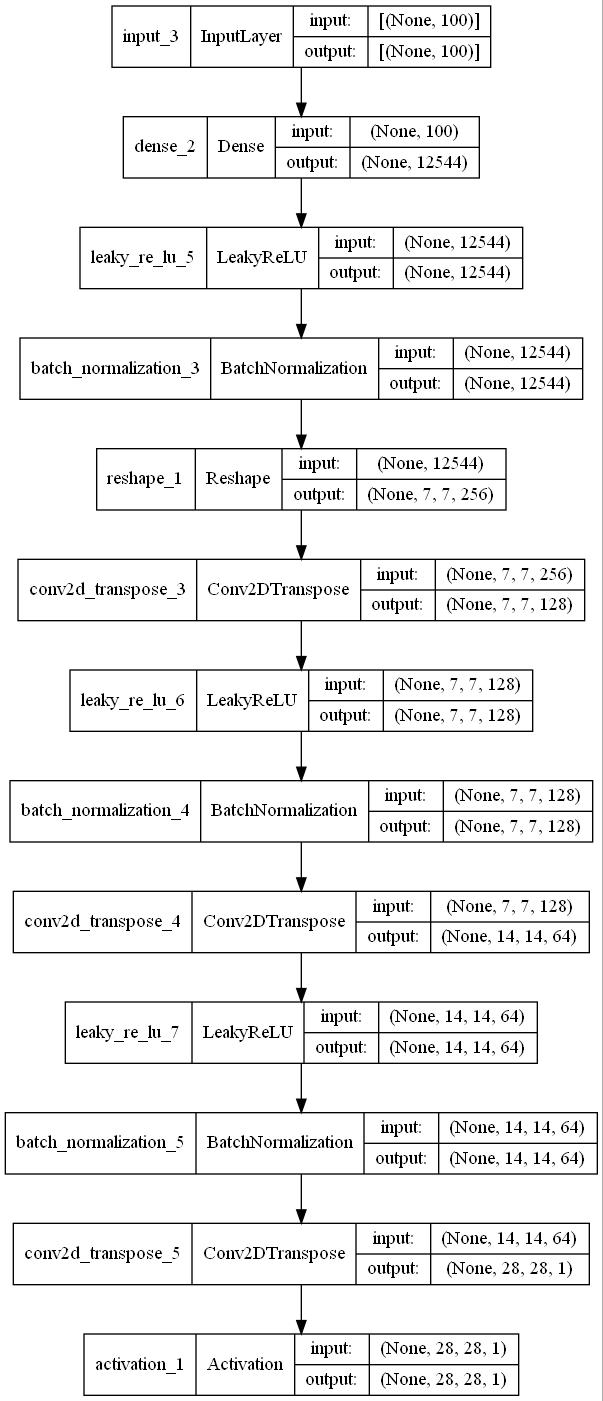

In [28]:
from tensorflow.keras.utils import plot_model
plot_model(gen, show_shapes=True, show_layer_names=True, to_file='generator_DCGAN_EMNIST.jpg')

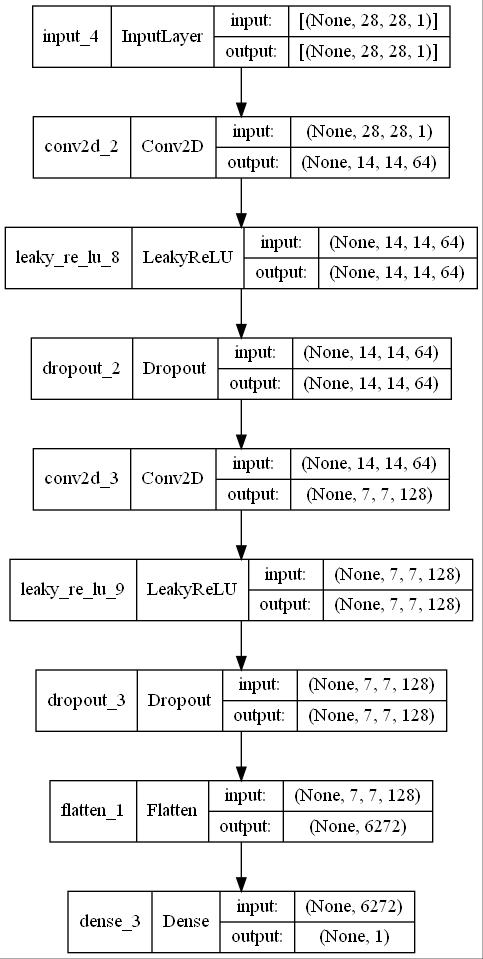

In [29]:
plot_model(dis, show_shapes=True, show_layer_names=True, to_file='disc_DCGAN_EMNIST.jpg')

  0%|          | 0/200 [00:00<?, ?it/s]

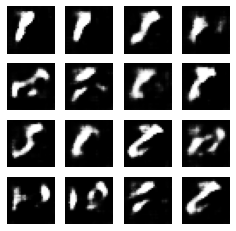

  2%|▏         | 3/200 [06:13<6:48:32, 124.43s/it]


KeyboardInterrupt: 

In [30]:
dcgan.train(train_dataset, test_seed, EPOCHS, BATCH_SIZE)

#####  INTERRUPTED BY ME  !!!  time-consuming process and I don't want to hurt my PC 